# Name: Tufan Kundu
# Reg no: 24MDT0184
# EDA lab
## 7 March, 2025

# Outlier detection in Iris dataset

### Using KNN method

### Importing the necessary libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


### Loading the dataset

In [2]:
iris = load_iris()

## Creating dataframe with feature names
df = pd.DataFrame(iris.data,columns = iris.feature_names)
df['target'] = iris.target

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [3]:
from sklearn.neighbors import NearestNeighbors 

k = 5

nbrs = NearestNeighbors(n_neighbors=k+1)
nbrs.fit(df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']])

distances, indices = nbrs.kneighbors(df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']])
avg_distance = distances[:,1:].mean(axis = 1)
df['Avg_Distance'] = avg_distance
threshold_knn = np.percentile(avg_distance, 95)
df['Outlier_KNN'] = df['Avg_Distance'] > threshold_knn
print("KNN method detected outliers(Without PCA):",df['Outlier_KNN'].sum())


KNN method detected outliers(Without PCA): 8


In [4]:
i1 = df[df['Outlier_KNN']== True].index
i1

Index([41, 98, 106, 109, 117, 118, 131, 135], dtype='int64')

## Applying PCA to the dataset and checking the results

In [5]:
features = iris.feature_names
x = df.loc[:,features].values

scaler = StandardScaler()
x_std = scaler.fit_transform(x)

pca = PCA(n_components=2)
principalcomponents = pca.fit_transform(x_std)

principaldf = pd.DataFrame(data = principalcomponents, columns=['PC1','PC2']) 


## Detecting the outliers using KNN

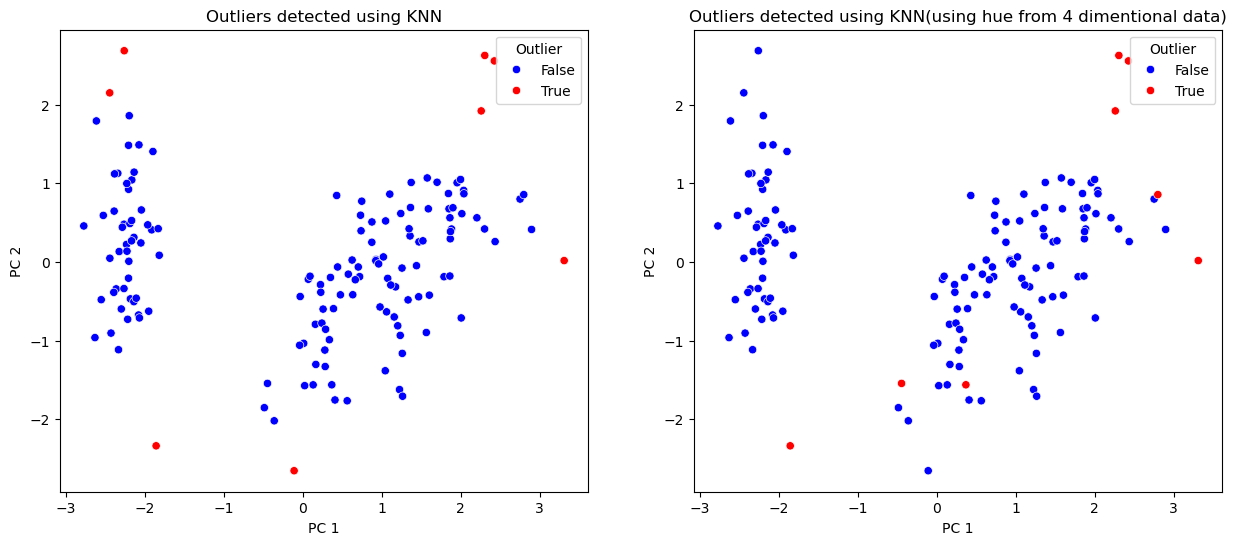

KNN method detected outliers(With PCA): 8


In [6]:
k = 5

nbrs = NearestNeighbors(n_neighbors=k+1)
nbrs.fit(principaldf[['PC1','PC2']])

distances, indices = nbrs.kneighbors(principaldf[['PC1','PC2']])
avg_distance = distances[:,1:].mean(axis = 1)

principaldf['Avg_Distance'] = avg_distance

threshold_knn = np.percentile(avg_distance, 95)

principaldf['Outlier_KNN'] = principaldf['Avg_Distance'] > threshold_knn

#plot the KNN outlier detection results
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)  
sns.scatterplot(x='PC1',y='PC2',data=principaldf,hue='Outlier_KNN',palette={False:'blue',True:'red'})
plt.title("Outliers detected using KNN")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title='Outlier')
plt.subplot(1,2,2)   
sns.scatterplot(x='PC1',y='PC2',data=principaldf,hue=df['Outlier_KNN'],palette={False:'blue',True:'red'})
plt.title("Outliers detected using KNN(using hue from 4 dimentional data)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title='Outlier')
plt.show()

print("KNN method detected outliers(With PCA):",principaldf['Outlier_KNN'].sum())

In [7]:
i2 = principaldf[principaldf['Outlier_KNN']== True].index
print(i1)
print(i2)

Index([41, 98, 106, 109, 117, 118, 131, 135], dtype='int64')
Index([15, 33, 41, 60, 109, 117, 118, 131], dtype='int64')


### Inference:
- We have detected same number of outliers using KNN with and without applying PCA
- Though the total number of outlier is the same but, the index of the outlier is not exactly the same, i.e different data points are outlier before and after applying PCA

## Using Mahalanobis Distance for outlier detection

In [8]:
from scipy.stats import chi2
cov_matrix = np.cov(df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].values.T)
cov_inv = np.linalg.inv(cov_matrix)

#Compute Mahalanobis distances for all observations.
m_dist = []

#Calculate the mean of the features to center the data.
mean_df = df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].mean().values

#Iterate through each row (observation) in the DataFrame.
for i, row in df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].iterrows():
    #Calculate the difference between the observation and the mean.
    diff = row.values - mean_df

    #Compute the Mahalanobis distance for the observation.
    md = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))

    m_dist.append(md)

#Add the Mahalanobis distances to the DataFrame.
df['Mahalanobis_dist'] = m_dist

#Determine the threshold from the chi-square distribution.
#dof: degrees of freedom, which is equal to the number of features (4 in this case).
dof = 4
alpha = 0.95 #Confidence level for the threshold (95% quantile)

#Calculate the threshold value (square root because we compute Euclidean-like distances).
threshold_maha = np.sqrt(chi2.ppf(alpha, dof))

#Flag observations as outliers if their Mahalanobis distance exceeds the threshold.
df['Outlier_Mahalanobis'] = df['Mahalanobis_dist'] > threshold_maha

#Print the number of outliers detected using the Mahalanobis method.
print("Mahalanobis method detected outliers(Without PCA):", df['Outlier_Mahalanobis'].sum())

Mahalanobis method detected outliers(Without PCA): 9


### Using the PCA applied dataset

In [9]:
cov_matrix = np.cov(principaldf[['PC1','PC2']].values.T)
cov_inv = np.linalg.inv(cov_matrix)

#Compute Mahalanobis distances for all observations.
m_dist = []

#Calculate the mean of the features to center the data.
mean_df = principaldf[['PC1','PC2']].mean().values

#Iterate through each row (observation) in the DataFrame.
for i, row in principaldf[['PC1','PC2']].iterrows():
    #Calculate the difference between the observation and the mean.
    diff = row.values - mean_df

    #Compute the Mahalanobis distance for the observation.
    md = np.sqrt(np.dot(np.dot(diff.T, cov_inv), diff))

    m_dist.append(md)

#Add the Mahalanobis distances to the DataFrame.
principaldf['Mahalanobis_dist'] = m_dist

#Determine the threshold from the chi-square distribution.
#dof: degrees of freedom, which is equal to the number of features (2 in this case).
dof = 2
alpha = 0.95 #Confidence level for the threshold (95% quantile)

#Calculate the threshold value (square root because we compute Euclidean-like distances).
threshold_maha = np.sqrt(chi2.ppf(alpha, dof))

#Flag observations as outliers if their Mahalanobis distance exceeds the threshold.
principaldf['Outlier_Mahalanobis'] = principaldf['Mahalanobis_dist'] > threshold_maha

#Print the number of outliers detected using the Mahalanobis method.
print("Mahalanobis method detected outliers(after applying PCA):", principaldf['Outlier_Mahalanobis'].sum())

Mahalanobis method detected outliers(after applying PCA): 6


## Visualizing

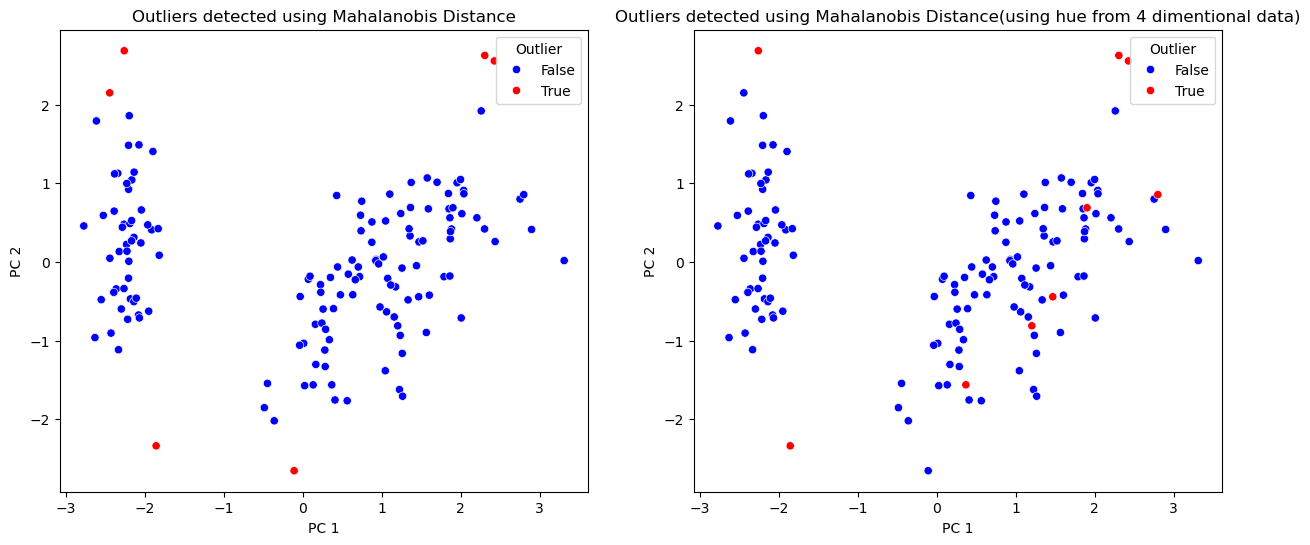

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)  
sns.scatterplot(x='PC1',y='PC2',data=principaldf,hue='Outlier_Mahalanobis',palette={False:'blue',True:'red'})
plt.title("Outliers detected using Mahalanobis Distance")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title='Outlier')
plt.subplot(1,2,2)   
sns.scatterplot(x='PC1',y='PC2',data=principaldf,hue=df['Outlier_Mahalanobis'],palette={False:'blue',True:'red'})
plt.title("Outliers detected using Mahalanobis Distance(using hue from 4 dimentional data)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title='Outlier')
plt.show()

### Inference:
- Using Mahalanobis Distance for outlier detection on the 4 features without PCA we have got 9 outliers and after applying PCA we got 6 outliers
- Data points of different index are identified as outliers before and after applying PCA.